# Topic

    Emotions increase our chances of survival by providing us with the ability to deal with sudden events in our surroundings.

    In a positve state, optimistic feelings dominate and cognitive functions (i.e. problem-solving, abilities.


## Interested Aspects / Analysis

### Questions 
1. Make predictions of timing:
  * Time that argument may happen 
  * Best time to approach each other
  * Time of possible impulsive decisions 
  * Time of tiredness (time for a break) 


2. Make predictions of the events: 
 * what event you are doing 


3. Notify the emotions: 
  * Showing the emotions right now (help them to link the event and the interactions with the emotions)


4. Give the notification for the possible outcome: 
  * (early warning) See the signals change, and give the instructions of what they should be doing in response to the situation (provide tailored advice for them to reach their set point at the moment)
  * (promote the positive experience) let them know they are relaxed and motivated, they should capture the moment < in a way I think the experiencing self can really help shape your experience and in turn shape the remembering self if we can give the instructions and the interventions at the moment)
  * Gives the warning if the signal shows the potential health issue <like if you are in danger and your physiological signal change dramatically they can contact your emergency contact directly)

### Analysis

1. Clustering with t-SNE and PCA on these features 
2. Seq-2-Seq for data every minute

# Data Preprocessing

In [37]:
import numpy as np 
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import sequence
import datetime
from scipy import stats

sns.set(color_codes = True)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Sampling frequency 64Hz ~= 0.015625 s
bvp = pd.read_csv('data/BVP.csv', header= None)
bvp.columns  = ['bvp']
print(len(bvp))
bvp.head()

2402644


,bvp
0,1.522203e+09
1,6.400000e+01
2,-0.000000e+00
3,-0.000000e+00
4,-0.000000e+00


In [3]:
print(bvp.iloc[0])

bvp    1.522203e+09
Name: 0, dtype: float64


In [4]:
init_time = datetime.datetime.utcfromtimestamp(bvp.iloc[0]).strftime('%Y-%m-%d %H:%M:%S')
init_time

'2018-03-28 02:05:40'

## EDA dataframe

In [7]:
# Sampling frequency 4Hz ~= 0.25s
eda = pd.read_csv('data/EDA.csv', header= None)
eda.columns  = ['eda']
# eda = eda.rolling(4).sum()
# eda = eda.dropna().reset_index(drop = True)
eda_freq = eda.iloc[1].values
print(len(eda))
print(eda.columns)
print('freq: ', eda_freq)
eda.head(10)

150164
Index(['eda'], dtype='object')
freq:  [4.]


,eda
0,1.522203e+09
1,4.000000e+00
2,0.000000e+00
3,1.153060e-01
4,1.691150e-01
5,1.742400e-01
6,1.742400e-01
7,1.755210e-01
8,1.768020e-01
9,1.768020e-01


In [8]:
eda = eda.iloc[2:]
eda.head(5)

,eda
2,0.000000
3,0.115306
4,0.169115
5,0.174240
6,0.174240


In [9]:
str(float(eda_freq))+'H'

'4.0H'

In [10]:
#create index 
time_eda = pd.date_range(start=init_time, periods=len(eda), freq=str(1/int(eda_freq))+'S')
time_eda

DatetimeIndex([       '2018-03-28 02:05:40', '2018-03-28 02:05:40.250000',
               '2018-03-28 02:05:40.500000', '2018-03-28 02:05:40.750000',
                      '2018-03-28 02:05:41', '2018-03-28 02:05:41.250000',
               '2018-03-28 02:05:41.500000', '2018-03-28 02:05:41.750000',
                      '2018-03-28 02:05:42', '2018-03-28 02:05:42.250000',
               ...
                      '2018-03-28 12:31:18', '2018-03-28 12:31:18.250000',
               '2018-03-28 12:31:18.500000', '2018-03-28 12:31:18.750000',
                      '2018-03-28 12:31:19', '2018-03-28 12:31:19.250000',
               '2018-03-28 12:31:19.500000', '2018-03-28 12:31:19.750000',
                      '2018-03-28 12:31:20', '2018-03-28 12:31:20.250000'],
              dtype='datetime64[ns]', length=150162, freq='250L')

In [11]:
eda=eda.set_index(time_eda, drop =True)
eda.head()

,eda
2018-03-28 02:05:40.000,0.000000
2018-03-28 02:05:40.250,0.115306
2018-03-28 02:05:40.500,0.169115
2018-03-28 02:05:40.750,0.174240
2018-03-28 02:05:41.000,0.174240


In [12]:
eda = eda.rolling(4).sum()
eda = eda.iloc[::4,:]
eda = eda.dropna()
print(len(eda))
eda.head()

37540


,eda
2018-03-28 02:05:41,0.632901
2018-03-28 02:05:42,0.704646
2018-03-28 02:05:43,0.709772
2018-03-28 02:05:44,0.709772
2018-03-28 02:05:45,0.700803


## HR dataframe

In [15]:
# Sampling frequency 1Hz ~= 1s
hr = pd.read_csv('data/HR.csv', header= None)
hr.columns  = ['hr']
hr_freq = hr.iloc[1].values
print(len(hr))
print('freq: ', hr_freq)
hr.head()

37534
freq:  [1.]


,hr
0,1.522203e+09
1,1.000000e+00
2,5.500000e+01
3,6.400000e+01
4,6.000000e+01


In [16]:
hr = hr.iloc[2:]
hr.head()

,hr
2,55.00
3,64.00
4,60.00
5,60.25
6,58.60


In [17]:
time_hr = pd.date_range(start=init_time, periods=len(hr), freq=str(1/float(hr_freq))+'S')
time_hr

DatetimeIndex(['2018-03-28 02:05:40', '2018-03-28 02:05:41',
               '2018-03-28 02:05:42', '2018-03-28 02:05:43',
               '2018-03-28 02:05:44', '2018-03-28 02:05:45',
               '2018-03-28 02:05:46', '2018-03-28 02:05:47',
               '2018-03-28 02:05:48', '2018-03-28 02:05:49',
               ...
               '2018-03-28 12:31:02', '2018-03-28 12:31:03',
               '2018-03-28 12:31:04', '2018-03-28 12:31:05',
               '2018-03-28 12:31:06', '2018-03-28 12:31:07',
               '2018-03-28 12:31:08', '2018-03-28 12:31:09',
               '2018-03-28 12:31:10', '2018-03-28 12:31:11'],
              dtype='datetime64[ns]', length=37532, freq='S')

In [18]:
hr = hr.set_index(time_hr, drop =True)

print(len(hr))
hr.head()

37532


,hr
2018-03-28 02:05:40,55.00
2018-03-28 02:05:41,64.00
2018-03-28 02:05:42,60.00
2018-03-28 02:05:43,60.25
2018-03-28 02:05:44,58.60


## Temperature dataframe

In [19]:
# Sampling frequency 4Hz ~= 0.25s
temp = pd.read_csv('data/TEMP.csv', header= None)
temp.columns  = ['temp']
# temp = temp.rolling(4).sum()
temp_freq = temp.iloc[1]
# temp = temp.dropna().reset_index(drop = True)
temp.columns = ['temp']
print(len(temp))
print(temp.columns)
print('temp_freq: ', temp_freq)
temp.head()

150162
Index(['temp'], dtype='object')
temp_freq:  temp    4.0
Name: 1, dtype: float64


,temp
0,1.522203e+09
1,4.000000e+00
2,3.495000e+01
3,3.495000e+01
4,3.495000e+01


In [20]:
temp = temp.iloc[2:]
temp.head()

,temp
2,34.95
3,34.95
4,34.95
5,34.95
6,34.95


In [21]:
time_temp = pd.date_range(start=init_time, periods=len(temp), freq=str(1/int(temp_freq))+'S')
time_temp

DatetimeIndex([       '2018-03-28 02:05:40', '2018-03-28 02:05:40.250000',
               '2018-03-28 02:05:40.500000', '2018-03-28 02:05:40.750000',
                      '2018-03-28 02:05:41', '2018-03-28 02:05:41.250000',
               '2018-03-28 02:05:41.500000', '2018-03-28 02:05:41.750000',
                      '2018-03-28 02:05:42', '2018-03-28 02:05:42.250000',
               ...
               '2018-03-28 12:31:17.500000', '2018-03-28 12:31:17.750000',
                      '2018-03-28 12:31:18', '2018-03-28 12:31:18.250000',
               '2018-03-28 12:31:18.500000', '2018-03-28 12:31:18.750000',
                      '2018-03-28 12:31:19', '2018-03-28 12:31:19.250000',
               '2018-03-28 12:31:19.500000', '2018-03-28 12:31:19.750000'],
              dtype='datetime64[ns]', length=150160, freq='250L')

In [22]:
temp = temp.set_index(time_temp, drop = True)
temp.head()

,temp
2018-03-28 02:05:40.000,34.95
2018-03-28 02:05:40.250,34.95
2018-03-28 02:05:40.500,34.95
2018-03-28 02:05:40.750,34.95
2018-03-28 02:05:41.000,34.95


In [23]:
# temp = temp.rolling(4).sum()
temp = temp.iloc[::4,:]
print(len(temp))
temp.head()

37540


,temp
2018-03-28 02:05:40,34.95
2018-03-28 02:05:41,34.95
2018-03-28 02:05:42,34.93
2018-03-28 02:05:43,34.89
2018-03-28 02:05:44,34.91


In [24]:
drop_eda = len(eda) - len(hr)
drop_temp = len(temp)  - len(hr)
eda = eda[:-drop_eda]
temp = temp[:-drop_temp]

In [25]:
print(len(eda))
print(len(hr))
print(len(temp))

37532
37532
37532


In [26]:
df = pd.concat([eda, hr, temp], axis = 1)
df.head()

,eda,hr,temp
2018-03-28 02:05:40,NaN,55.00,34.95
2018-03-28 02:05:41,0.632901,64.00,34.95
2018-03-28 02:05:42,0.704646,60.00,34.93
2018-03-28 02:05:43,0.709772,60.25,34.89
2018-03-28 02:05:44,0.709772,58.60,34.91


In [27]:
df = df.dropna()

In [29]:
print(len(df))
df.head()

37531


,eda,hr,temp
2018-03-28 02:05:41,0.632901,64.00,34.95
2018-03-28 02:05:42,0.704646,60.00,34.93
2018-03-28 02:05:43,0.709772,60.25,34.89
2018-03-28 02:05:44,0.709772,58.60,34.91
2018-03-28 02:05:45,0.700803,58.83,34.93


## Preprocessing the data 

In [38]:
#Take off the outliers
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
df.head()

,eda,hr,temp
2018-03-28 02:05:41,0.632901,64.00,34.95
2018-03-28 02:05:42,0.704646,60.00,34.93
2018-03-28 02:05:43,0.709772,60.25,34.89
2018-03-28 02:05:44,0.709772,58.60,34.91
2018-03-28 02:05:45,0.700803,58.83,34.93


## Plots

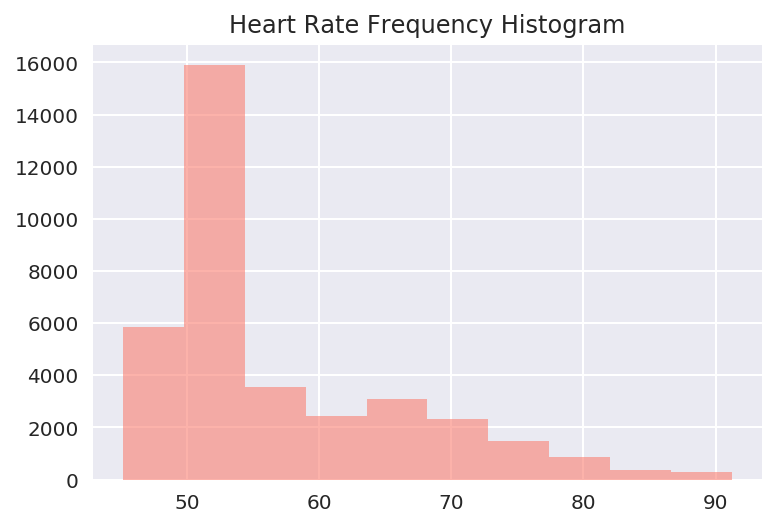

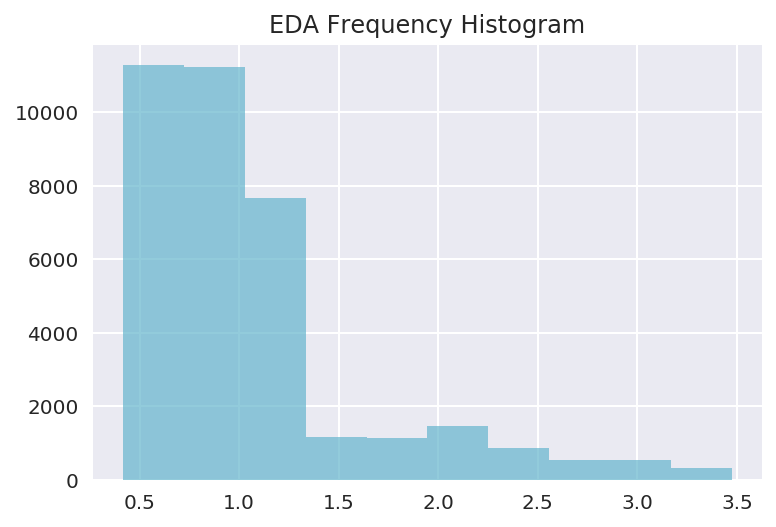

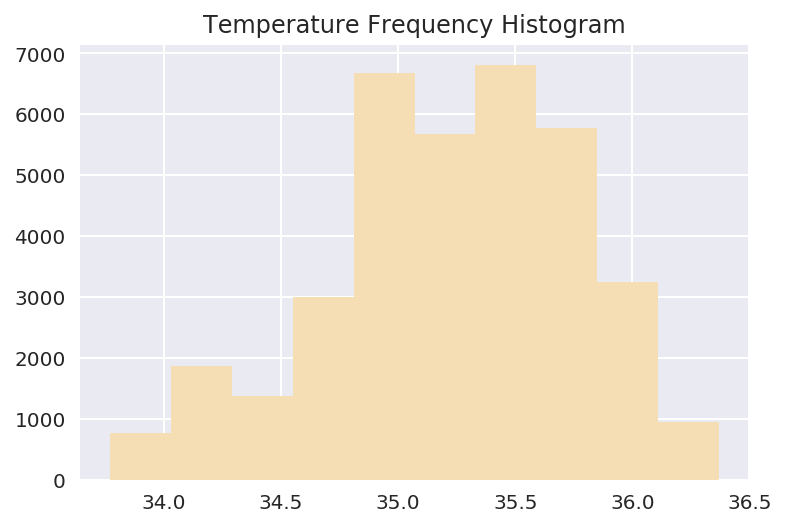

In [39]:
plt.hist(df.hr, color = 'salmon',alpha = 0.6)
plt.title('Heart Rate Frequency Histogram')
plt.show()

plt.hist(df.eda, color = 'c', alpha = 0.7)
plt.title('EDA Frequency Histogram')
plt.show()

plt.hist(df.temp, color = 'wheat')
plt.title('Temperature Frequency Histogram')
plt.show()

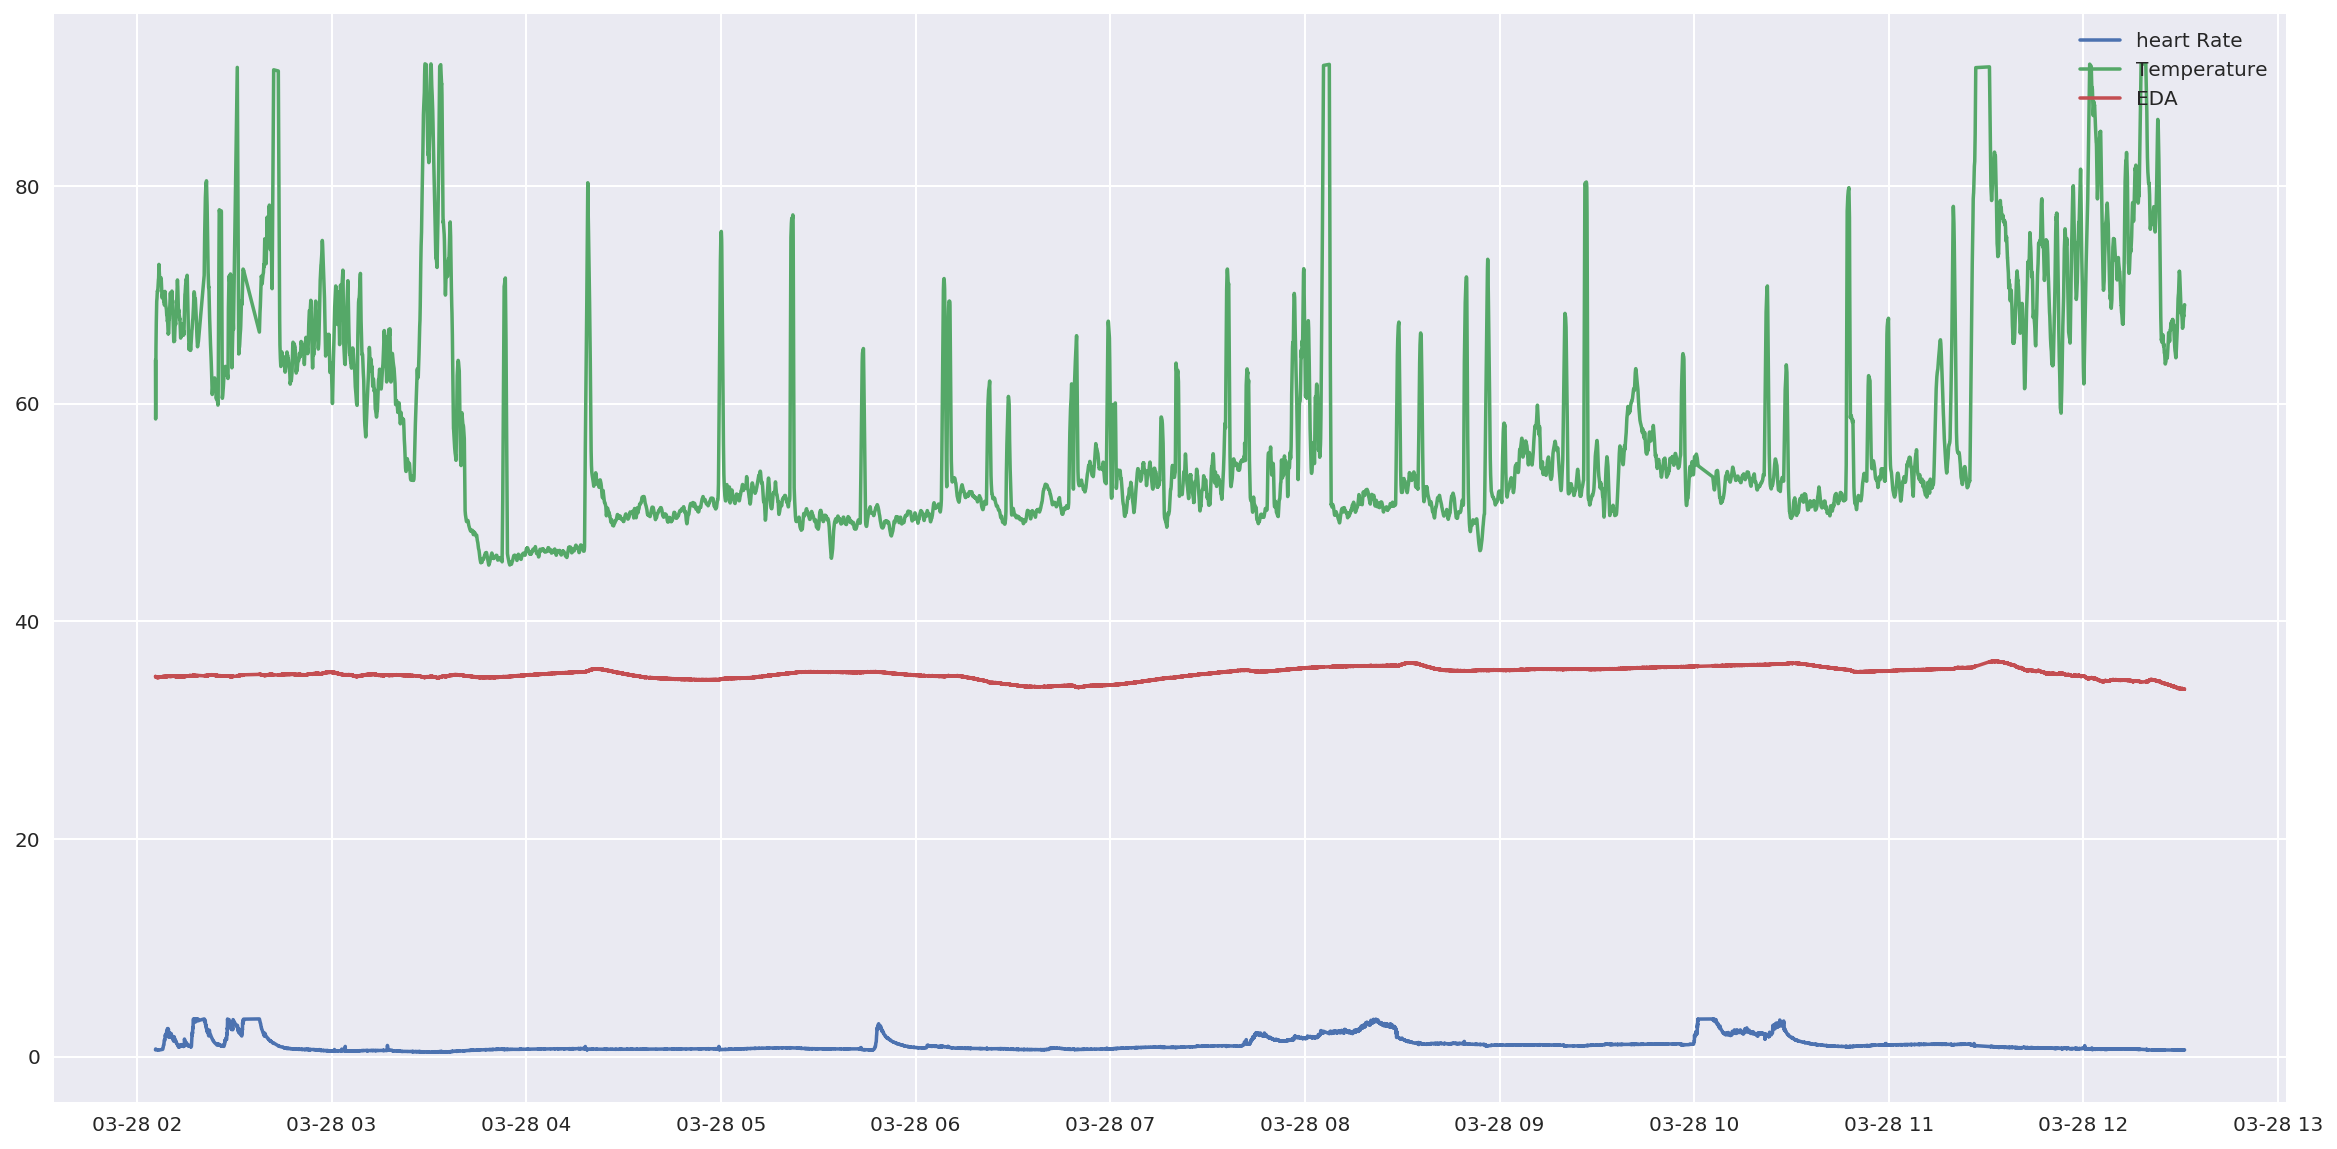

In [50]:
# fig = plt.gcf()
# fig.set_size_inches(18.5, 10.5, forward=True)
plt.figure(figsize=(20,10))
plt.plot(df)
plt.legend(['heart Rate','Temperature','EDA'],loc=1,fontsize='medium')

plt.show()